# Ch. 9 - Feature engineering & data preparation
In this chapter we will prepare the data we got from the bank marketing campaign. We will examine it closely, clean it up and make it ready for our neural network.

## Preparing out tools
Before starting out on the actual analysis, it makes sense to prepare the tools of trade. We will use four libraries:

In [1]:
# As always, first some libraries
# Numpy handles matrices
import numpy as np
# Pandas handles data 
import pandas as pd
# Matplotlib is a plotting library
import matplotlib.pyplot as plt
# Set matplotlib to render imediately
%matplotlib inline
# Seaborn is a plotting library built on top of matplotlib that can handle some more advanced plotting
import seaborn as sns

To make our charts look nice, we will use the FiveThirtyRight color scheme. [FiveThirtyEight](http://fivethirtyeight.com/) is a quantitative journalism website that has built a very nice graph scheme. So to make this chapter pretty, we will use their scheme.

In [2]:
# Define colors for seaborn
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
# Tell seaborn to use the 538 colors
sns.set(palette=five_thirty_eight)

## The data
The data is taken from [Moro et al., 2014](https://archive.ics.uci.edu/ml/datasets/bank+marketing) via the UCI machine learning repository. The balanced version we are working with is included in the GitHub repository.

In [3]:
# Load data with pandas
df = pd.read_csv('balanced_bank.csv',index_col=0)

## Getting an overview
The first step in data preparation is to check what we are actually working with. After we have surveyed the dataset as a whole we will look at the individual features in it. As a start we can use pandas ```head()```function to get the first few rows of the dataset for a manual overview.

In [4]:
# Display first five rows for a rough overview
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
34579,35,admin.,single,university.degree,no,yes,no,cellular,may,thu,...,1,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
446,42,technician,married,professional.course,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
20173,36,admin.,married,university.degree,no,no,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes
18171,37,admin.,married,high.school,no,yes,yes,telephone,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,yes
30128,31,management,single,university.degree,no,yes,no,cellular,apr,thu,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,no


As we can see, there are 21 columns, 20 features plus the output. We can also see that categorical data is saved in text form. That is, instead of using numbers to indicate a category it uses text such as 'married' to indicate a marital status. We can also see an 'unknown' in the default column. That is, the value is not missing, but it is set to the text 'unknown'. We will have to decide later on how we want to deal with unknowns, first, lets check whether there is any actual data missing:

In [5]:
# Count missing values per column
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There seem to be no missing values, good! But as we noted earlier, some values might be 'unknown'. Let's check the data types we are dealing with. There are three common datatypes we might encounter:
- int: integers (1,2,3,4,...)
- float: floating point numbers with decimals (1.123,1.124,...)
- object: some non numeric data type, often text

In [6]:
# Display datatypes
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Job
Next on our feature list is the job that people have. This is a categorical variable currently in text form. We will search for obvious correlations with the output and see whether we can do any clever feature engineering. Since this is a categorical variable, we need to define a new function to draw the frequencies by outcome.

In [7]:
# Function to draw frequencies by outcome
def draw_conditional_barplot(feature,df):
    # Set matplotlib style
    plt.style.use('fivethirtyeight')
    # Count the total yes responses in our dataset
    n_yes = len(df[df.y == 'yes'])
    # Count the total no responses in our dataset
    n_no = len(df[df.y == 'no'])
    # Count the frequencies of the different jobs for the yes people
    yes_cnts = df[df.y == 'yes'][feature].value_counts() / n_yes * 100
    # Count frequencies of jobs for the nay sayers
    no_cnts = df[df.y == 'no'][feature].value_counts() / n_no * 100
    
    # A potential problem of creating two different frequency tables is that if one group (perhaps the yes crowd)...
    # ... does not include a certain category (like a certain job) then it will not be in the frequency tables at all
    # ... So we have to join them in one table to ensure that all categories are included
    # ... When merging the frequncy tables, missing categories will be marked with 'NA'
    # ... We can then replace all NAs with zeros, which is the correct frequency
    
    # Create a new dataframe that includes all frequencies
    res = pd.concat([yes_cnts,no_cnts],axis=1)
    # Name the columns of the new dataframe (yes crowd and nay sayers)
    res.columns = ['yes','no']
    # Fill empty fields with zeros
    res = res.fillna(0)
    
    # N = number of categories
    N = len(res['yes'])
    # Create an array for the locations of the group (creates an array [0,1,2,...,N])
    ind = np.arange(N) 
    # Specify width of bars
    width = 0.35   
    # Create empty matplotlib plot
    fig, ax = plt.subplots()
    # Add bars of the nay sayers
    rects1 = ax.bar(ind, res['no'], width)
    # Add bars of the yes crowd
    rects2 = ax.bar(ind + width, res['yes'], width)

    # Add label: feature name (e.g. job) in percent
    ax.set_ylabel(feature + ' in percent')
    # Add title
    ax.set_title(feature + ' by conversion')
    # Add ticks 
    ax.set_xticks(ind + width / 2)
    # Add categorie names as tick labels
    ax.set_xticklabels(res.index.values)
    # Rotate labels 90 degrees
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90)

    # Add legend
    ax.legend((rects1[0], rects2[0]), ('No', 'Yes'))
    
    # Render plot
    plt.show()

Now we can draw our conditional barplot

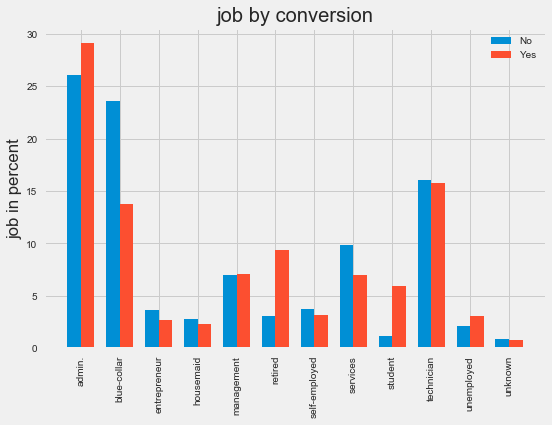

In [8]:
draw_conditional_barplot('job',df)

Students and retirees seem to be eager to subscribe. Both jobs are highly correlated with age, so we might have captured this already. The other jobs seem to be a bit more mixed. What we can also see from this chart is that there is a relatively small number of different jobs in the dataset, with just three groups (administrators, blue-collar workers, technicians) making up the bulk of customers in the data set. We also see that there are relatively few customers whose jobs are unknown. We will simply treat it as its own category here. Now we can convert this categorical variable into a set of dummy variables:

In [9]:
# Add job_ to every value in jobs so that the dummies have readable names
df['job'] = 'job_' + df['job'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['job'])

# Add dummies to dataframe
df = pd.concat([df,dummies],axis=1)

# Remove original job column
del df['job']

## Theory: What are dummy variables and why do we use them?
[Dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) are proxy variables for qualitative information. They convert cateogrical data into mutually exclusive features. So in the case of the jobs the turn the textual information ('admin', 'blue-collar', etc.) into new features that describe weather an instance is members of a certain category or not. Is this customers job admin (yes /no) is this customers job blue-collar (yes / no) and so on. This enables us to use qualitative information in our quantiative model. You can see how the single job feature was turned into a bunch of new features if we print out the data types again:

In [10]:
df.dtypes

age                    int64
marital               object
education             object
default               object
housing               object
loan                  object
contact               object
month                 object
day_of_week           object
duration               int64
campaign               int64
pdays                  int64
previous               int64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
y                     object
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
dtype: object

### Age
The age is the age of the client in years. As we can see from the datatype, it is an integer. It might be interesting to see weather age has any direct influence on weather a customer subscribes. We will draw a conditional distribution plot that shows the age distribution of all customers that said yes and of those that said no.

In [11]:
# Function to draw conditional distribution plot splot by weather the customer subscribed
def draw_conditional_distplot(feature,df):
    # Seat seaborn to use nice colors
    sns.set(palette=five_thirty_eight)
    # Draw the no plot
    sns.distplot(df[df.y == 'no'][feature],label='no')
    # Draw the yes plot
    sns.distplot(df[df.y == 'yes'][feature],label='yes')
    # Draw the legend
    plt.legend()
    # Display the plot
    plt.show()

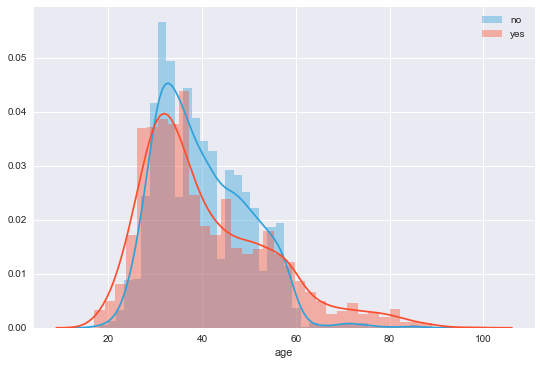

In [12]:
# Now we can just use the function defined above
draw_conditional_distplot('age',df)

There is a couple of useful findings in here. First, over a certain age, around 60 a lot of people subscribed! Between 35 and 60 the nay sayers have the upper hand while below 35 it seems to be a little more of the yes crowd. We can probably improve our forcasts if we don't treat age as a [ratio variable](https://www.graphpad.com/support/faqid/1089/) but split it into three buckets and treat those as categorical variables.

In [13]:
# Create old people group
df['age_old'] = np.where(df['age'] >= 60, 1,0)
# Create mid age people group
df['age_mid'] = np.where((df['age'] <= 60) & (df['age'] >= 35), 1,0)
# Create young people group
df['age_young'] = np.where(df['age'] <= 35, 1,0)

Now, the feature age itself is redundant and we can remove it

In [14]:
# Remove original age
del df['age']

Now we can see that the original age is gone but we have three new categorical variables

### Marital status
Marital status is one of the common variables many firms collect about their customers. It usually correlates highly with age, although through the rise of divorce rates this relationship is in decline. We will plot our conditional barplot again to get an overview.

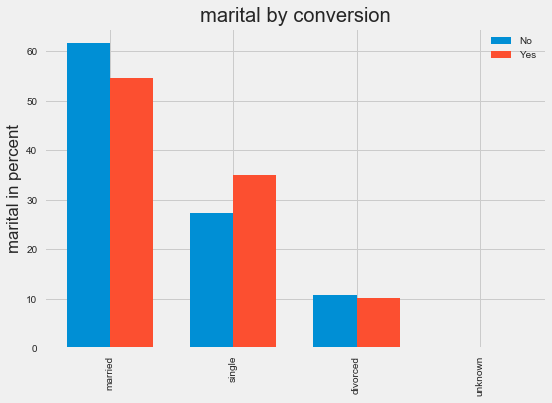

In [15]:
draw_conditional_barplot('marital',df)

The majority of people called where married, there seems to be no category 'widow', only 'single' which decreases the correlation with age. While there are some unknowns, they make up for a tiny fraction, so again, we will just treat it as its own category. There seem to be some differences between married and single people, but the difference is quite small. However, there might be some higher order correlation of combined features and the outcome of which marital status is a part. We will convert this one to dummy variables as well.

In [16]:
# Add marital_ to every value in marital so that the dummies have readable names
df['marital'] = 'marital_' + df['marital'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['marital'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['marital']

### Education
Education is another standard demographic variable, so we will proceed as we did with the marital status.

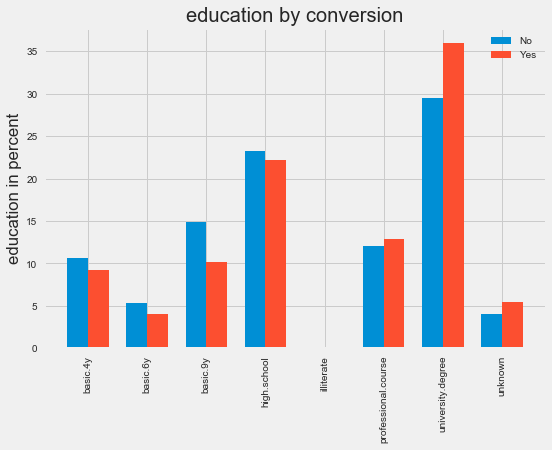

In [17]:
draw_conditional_barplot('education',df)

In [18]:
# Add education_ to every value in education so that the dummies have readable names
df['education'] = 'education_' + df['education'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['education'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['education']

### Default
Weather the client has a credit in default.

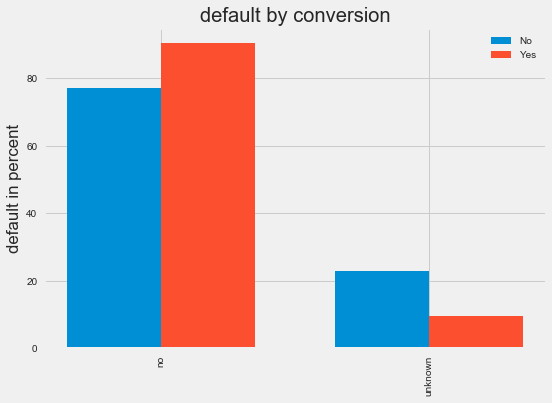

In [19]:
draw_conditional_barplot('default',df)

Here, 'unknown' makes for an interesting feature. If the bank does not know weather the client defaulted before, the sales agent might have to ask because the bank might not want to sign up defaulting customers. We can see, that relatively more members of the nay sayers have unknowns default status than of the yes crowd. There are very few people who have defaulted, it is not even visible in the chart. We will give the numbers a closer look.

In [20]:
# This code was copied from our barchart plotting function, but we will print out the numbers instead of plotting them
# Count total yes responses
n_yes = len(df[df.y == 'yes'])
# Count the total no responses in our dataset
n_no = len(df[df.y == 'no'])
# Count the frequencies of the different jobs for the yes people
yes_cnts = df[df.y == 'yes']['default'].value_counts() / n_yes * 100
# Count frequencies of jobs for the nay sayers
no_cnts = df[df.y == 'no']['default'].value_counts() / n_no * 100

# Create a new dataframe that includes all frequencies
res = pd.concat([yes_cnts,no_cnts],axis=1)
# Name the columns of the new dataframe (yes crowd and nay sayers)
res.columns = ['yes','no']
# Fill empty fields with zeros
res = res.fillna(0)

print(res)

               yes         no
no       90.452586  77.155172
unknown   9.547414  22.844828


A tiny share of the nay sayers defaulted earlier, while none of the yes crowd did. A significant higher share of the nay sayers had an unknown status. This will make for an interesting feature, we will convert it to dummy variables as well.

In [21]:
# Ensure dummy names are well readable
df['default'] = 'default_' + df['default'].astype(str)
# Get dummies
dummies = pd.get_dummies(df['default'])
# Get dummies
dummies = pd.get_dummies(df['default'])
# Add dummies to df
df = pd.concat([df,dummies],axis=1)
#remove original column
del df['default']

### Housing
Weather a customer has a housing loan.

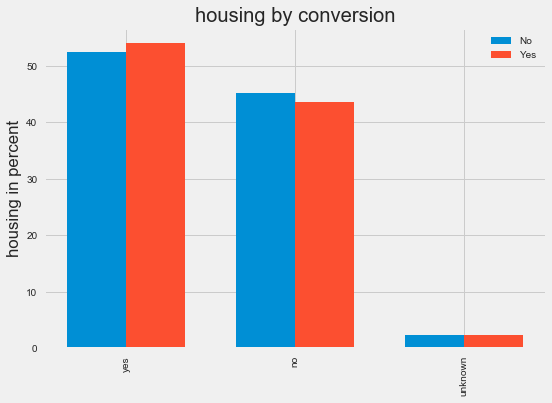

In [22]:
draw_conditional_barplot('housing',df)

While this one does not look very interesting, we will convert it to a dummy variable and add it in, as it might have a correlation to the outcome in correlation with other variables.

In [23]:
# Ensure dummy names are well readable
df['housing'] = 'housing_' + df['housing'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['housing'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['housing']

### Loan
Weather the customer has a personal loan.

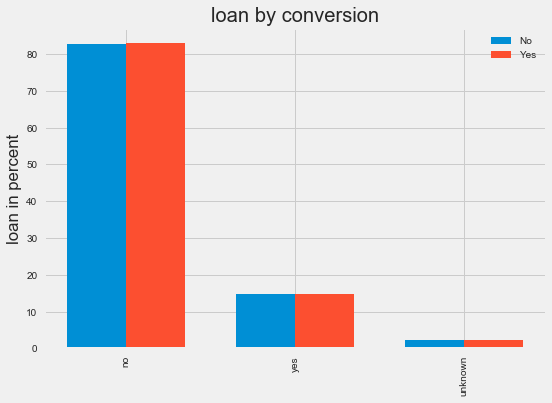

In [24]:
draw_conditional_barplot('loan',df)

No obvious observations here, convert to dummies and proceed.

In [25]:
# Ensure dummy names are well readable
df['loan'] = 'loan_' + df['loan'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['loan'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['loan']

### Type of contact
How the customer is contacted, cellphone or land line (marked as 'telephone')

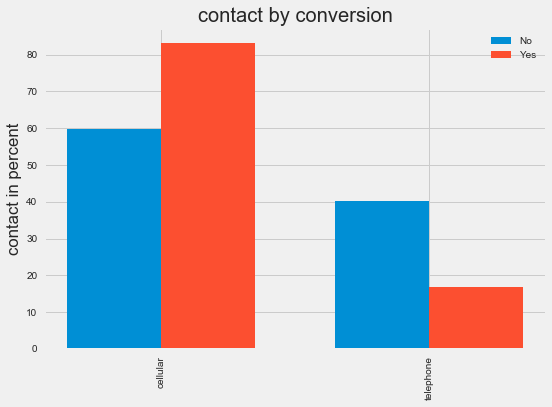

In [26]:
draw_conditional_barplot('contact',df)

Cellphones seem to be more popular overall but also a bit more successful. Probably calls on landlines are missed more often.

In [27]:
# Ensure dummy names are well readable
df['contact'] = 'contact_' + df['contact'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['contact'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['contact']

### Month of the call
The month in which the call was made.

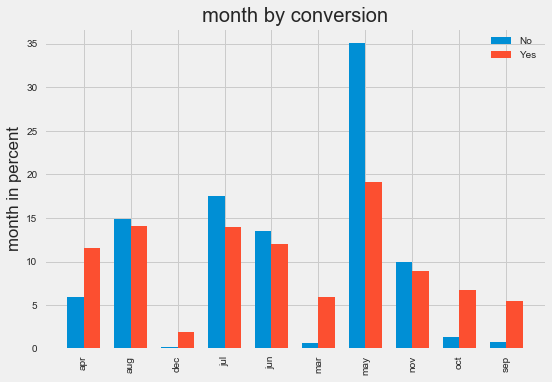

In [28]:
draw_conditional_barplot('month',df)

This graph is quite interesting: In december, there seems to have been very little calling. And while the yes crowd signed up pretty equally through the year, the nay sayers are more unevenly spread. There seems to have been a bigger push in the summer, in which many calls where made, but the share of successful calls declined. Again, this one will be converted into dummy variables.

In [29]:
# Ensure dummy names are well readable
df['month'] = 'month_' + df['month'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['month'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['month']

### Day of the call
The week day the call was made.

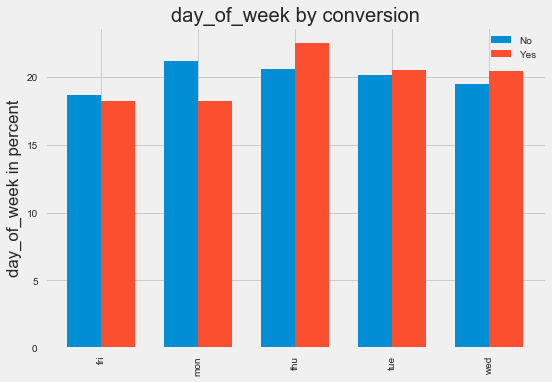

In [30]:
draw_conditional_barplot('day_of_week',df)

Interestingly, this bank does not seem to call people on the weekend. There also seem to be a bit fewer calls on fridays. Thursday seems to be the best day with the most total calls made and the most customers signed on.

In [31]:
# Add job_ to every value in jobs so that the dummies have readable names
df['day_of_week'] = 'day_of_week_' + df['day_of_week'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['day_of_week'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['day_of_week']

### Previous outcome
The outcome of previous calls to the customer.

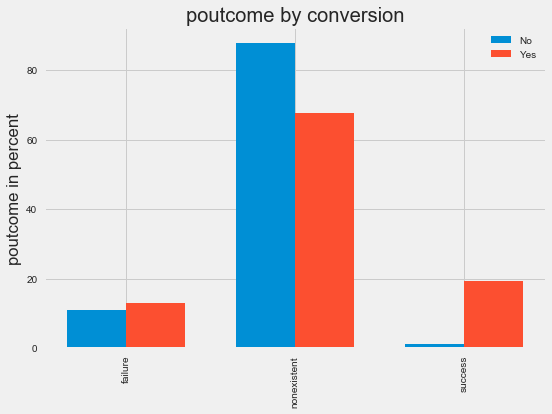

In [32]:
draw_conditional_barplot('poutcome',df)

Perhaps unsurprisingly, customers that said yes before are more likely to say yes again. Interestingly, customers that said no before, are also a little bit more likely to say yes this time. Customers that where not contacted before seem to say no most of the time.

In [33]:
# Add job_ to every value in jobs so that the dummies have readable names
df['poutcome'] = 'poutcome_' + df['poutcome'].astype(str)

# Get dummies
dummies = pd.get_dummies(df['poutcome'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['poutcome']

### Duration of the call
As any sales person knows, how long the customer is willing to stay on the phone greatly influences the likely hood of success.

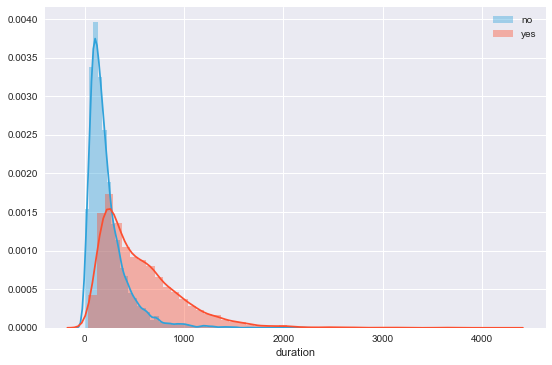

In [34]:
draw_conditional_distplot('duration',df)

And in fact, we can see that the duration of the call has a close correlation with the outcome. However, once the duration of the call is known, the outcome is also known, and we can not estimate the duration of the call in advance. So we can not use this feature for our forecast and have to remove it.

In [35]:
del df['duration']

### Number of contacts during this campaign
From the dataset description:
> Number of contacts performed during this campaign and for this client (numeric, includes last contact)

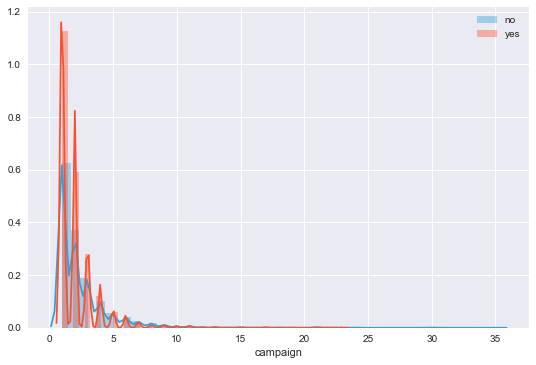

In [36]:
draw_conditional_distplot('campaign',df)

This graph is a little bit hard to read as there is a long tail of customers who have had many contacts. We will plot it again without the long tail.

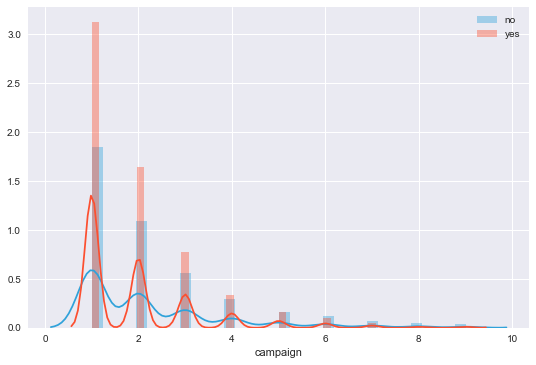

In [37]:
draw_conditional_distplot('campaign',df[df.campaign < 10])

In the smaller range, there seems to be a negative correlation between the number of contacts and the likely hood of a yes. Since there is a very long tail that will distort the actual data, we will clip the value to 10 before scaling the data.

In [38]:
df['campaign'] = df['campaign'].clip(upper = 10)

In [39]:
df['campaign'] = (df['campaign'] - df['campaign'].mean())/(df['campaign'].std())

## Theory: Feature scaling
[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) through standardization is a method that ensures that all input features have the same mean and standard deviation. This makes it easier for our learning algorithm to work with them since all features have the same 'scale'. In raw data, age and economic indicators such as the euribor rate might have very different ranges. While age has values between 20 and 100, the euribor will never be this high. The learning algorithm might then detect stronger or weaker correlations between certain variables just because their scales are very different. When all input features have the same mean and standard deviation, this hurdle is resolved. We can also picture this graphically. Remember that our learning algorithm is using gradient descent to optimize parameters for a minimum loss. If the 'valley' is very narrow it can be hard to find the minimum as the learning algorithm is often jumping over it. Feature scaling makes the valley more round and therefore easier to find the minimum.
![feature scaling](./assets/feature_scaling.jpg)

### Days since last contact
The number of days that passed since the customer was last contacted. 999 means they where not contacted before. We will therefore plot it without this outlier data.

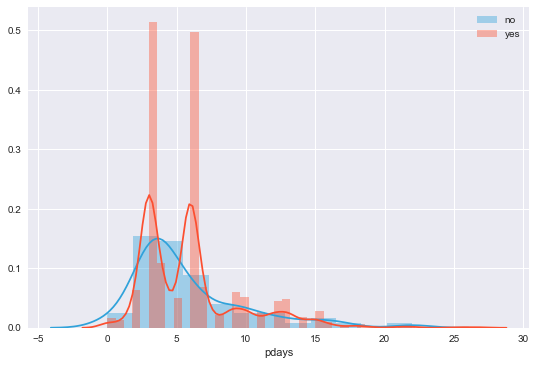

In [40]:
draw_conditional_distplot('pdays',df[df['pdays'] < 500])

We can see that if we cut off the values greater than 500 the next greatest value seems to be around 30. For customers not contacted before we will create a new dummy variable not contacted before.

In [41]:
df['contacted_before'] = np.where(df['pdays'] == 999, 0,1)

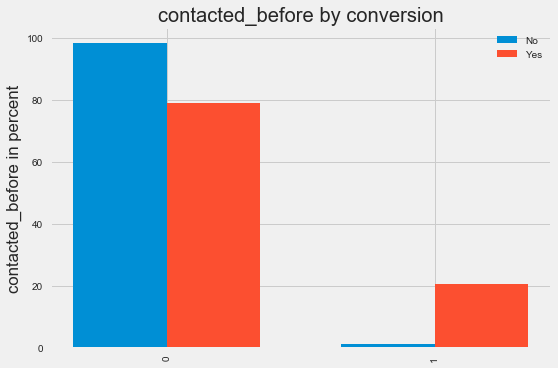

In [42]:
draw_conditional_barplot('contacted_before',df)

As we can see, that most customers have not been contacted before, those that have are more likely to say yes. To not distort our data, we will set the value of days till contact for those which have not been contacted before to the mean contact time.

In [43]:
df['pdays'] = np.where(df['pdays'] == 999,df[df['pdays'] < 999]['pdays'].mean(),df['pdays'])

We will see that now the large majority of values are at the mean of the distribution.

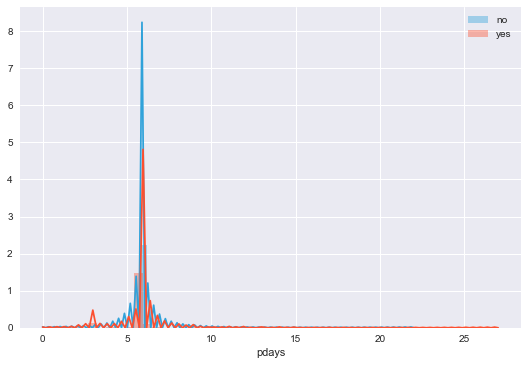

In [44]:
draw_conditional_distplot('pdays',df)

Now we can scale the data:

In [45]:
df['pdays'] = (df['pdays'] - df['pdays'].mean())/(df['pdays'].std())

### Number of contacts without last contact
Our data set also includes the number of contacts excluding the last one. Let's see weather it is different:

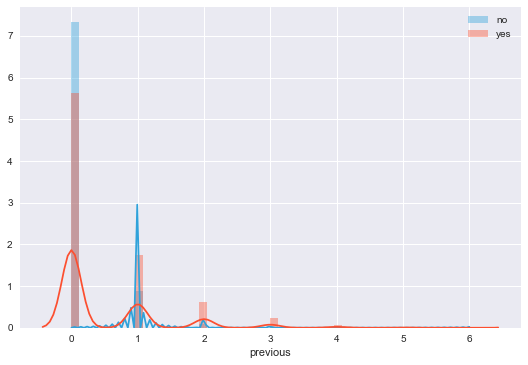

In [46]:
draw_conditional_distplot('previous',df)

We see that this feature shows a different pattern than the number of contacts including the last one. It now shows that more contacts are relatively better. We will scale the feature and include it:

In [47]:
df['previous'] = (df['previous'] - df['previous'].mean())/(df['previous'].std())

## Economic indicators
Our dataset also features a set of economic indicators. We will not discuss these in depth, instead we will just check them for distorting long tails and scale them.

### Employment variation rate

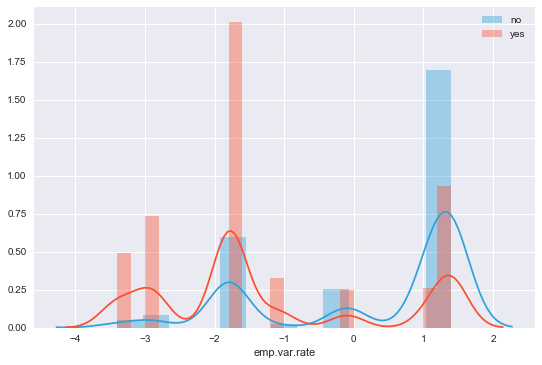

In [48]:
draw_conditional_distplot('emp.var.rate',df)

In [49]:
# Feature scaling
df['emp.var.rate'] = (df['emp.var.rate'] - df['emp.var.rate'].mean())/(df['emp.var.rate'].std())

### Consumer price index

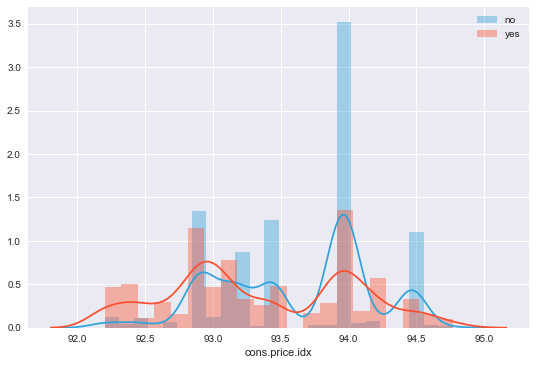

In [50]:
draw_conditional_distplot('cons.price.idx',df)

In [51]:
# Feature scaling
df['cons.price.idx'] = (df['cons.price.idx'] - df['cons.price.idx'].mean())/(df['cons.price.idx'].std())

### Consumer confidence index

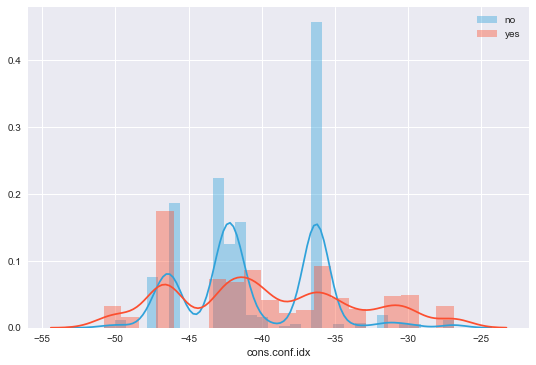

In [52]:
draw_conditional_distplot('cons.conf.idx',df)

In [53]:
# Feature scaling
df['cons.conf.idx'] = (df['cons.conf.idx'] - df['cons.conf.idx'].mean())/(df['cons.conf.idx'].std())

### 3 month euribor

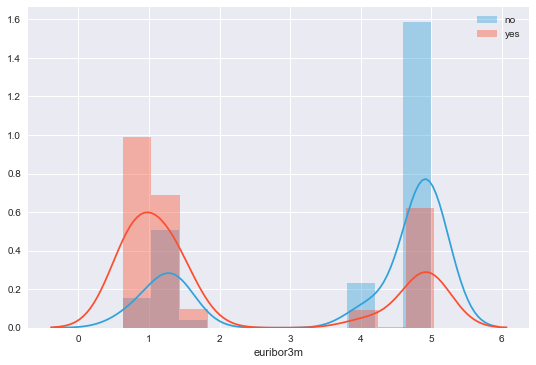

In [54]:
draw_conditional_distplot('euribor3m',df)

In [55]:
df['euribor3m'] = (df['euribor3m'] - df['euribor3m'].mean())/(df['euribor3m'].std())

### Employment number

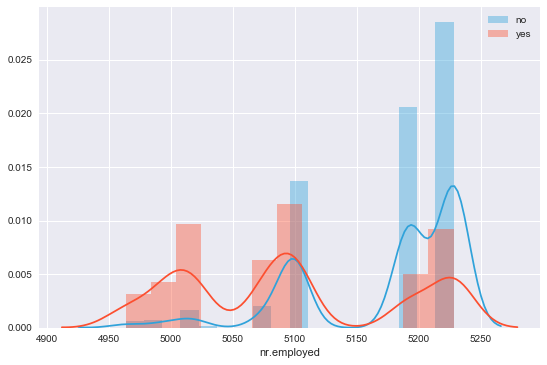

In [56]:
draw_conditional_distplot('nr.employed',df)

In [57]:
# Feature scaling
df['nr.employed'] = (df['nr.employed'] - df['nr.employed'].mean())/(df['nr.employed'].std())

## The output $y$
Our output $y$ is weather a customer subscribed (yes) or not (no).

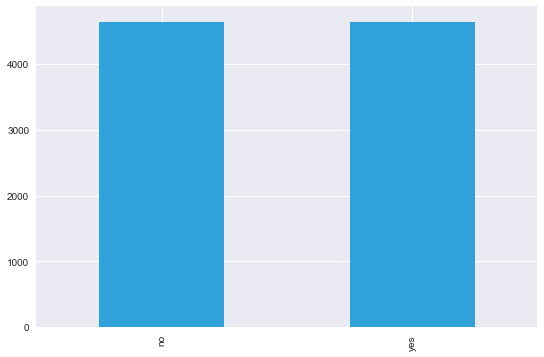

In [58]:
cnts = df.y.value_counts()
cnts.plot(kind='bar')

As you can see our outcome is balanced, as many customers subscribed as customer did not subscribed. You can also see that our output is still a text, we will convert it so that a yes is indicated by a 1, a no indicated by a 0.

In [59]:
# Conversion
df['y'] = np.where(df['y'] == 'yes', 1,0)

## Overview of new features
We have created a lot of new features in this chapter, we will now look at them all and check weather we have left any features as text.

In [60]:
pd.set_option('display.max_rows', 100)
df.dtypes

campaign                         float64
pdays                            float64
previous                         float64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
y                                  int64
job_admin.                         uint8
job_blue-collar                    uint8
job_entrepreneur                   uint8
job_housemaid                      uint8
job_management                     uint8
job_retired                        uint8
job_self-employed                  uint8
job_services                       uint8
job_student                        uint8
job_technician                     uint8
job_unemployed                     uint8
job_unknown                        uint8
age_old                            int64
age_mid                            int64
age_young                          int64
marital_divorced

## Saving the processed file
Our data looks good, so we will now save our processed data so we have it ready for building our model in the next chapter.

In [61]:
df.to_csv('processed_bank.csv')

### Summary
In this chapter you have seen an example data processing step. You have learned about dummy variables, feature scaling and how clever feature engineering can get better results out of the data. Data preprocessing actually makes up for the majority of time engineers spend when they build industry applications. It can easily make the difference between a well working system and one that does not work at all. Sometimes, it makes sense to come back to the feature engineering step after you have tried out some models. Often, insights from model building help you to do your feature engineering even better. And perhaps you have find something that could be done better in this chapter. If so, please file an issue on [GitHub](https://github.com/JannesKlaas/MLiFC) so we can improve. In the next chapter we will build a model on top of our processed data.